QTM 350 Final Project Analysis Script

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


df = pd.read_csv("../datasets/wdi_data.csv")

We began by removing non-country rows, such as metadata footers, to retain only valid observations. The dataset was then reshaped from wide to long format by unpivoting year columns, converting text-based year labels into numeric form, and filtering out missing or placeholder values. Finally, we pivoted indicators into separate columns, renamed them for clarity, converted all values to numeric, and dropped rows with no usable data to produce a clean, analysis-ready dataset.

1. Dataset cleaning

In [2]:
df = df[df["Country Name"].notna()]

year_cols = [col for col in df.columns if "YR" in col]
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=year_cols,
    var_name="Year", value_name="Value"
)

df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

df_long = df_long[df_long["Value"].notna()]
df_long = df_long[df_long["Value"] != ".."]

df_wide = df_long.pivot(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="Value"
).reset_index()

df_wide = df_wide.rename(columns={
    "Life expectancy at birth, total (years)": "LifeExpectancy",
    "Fertility rate, total (births per woman)": "FertilityRate",
    "Population growth (annual %)": "PopGrowth",
    "School enrollment, primary (% gross)": "PrimaryEnrollGross"
})

for col in ["LifeExpectancy", "FertilityRate", "PopGrowth", "PrimaryEnrollGross"]:
    df_wide[col] = pd.to_numeric(df_wide[col], errors="coerce")

df_clean = df_wide.dropna(
    subset=["LifeExpectancy", "FertilityRate", "PopGrowth", "PrimaryEnrollGross"],
    how="all"
)

df_clean.head(10)


Series Name,Country Name,Country Code,Year,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
0,Afghanistan,AFG,1970,7.400,37.460,2.445206,33.420010
1,Afghanistan,AFG,1971,7.432,37.932,2.428516,34.331341
2,Afghanistan,AFG,1972,7.453,38.423,2.442584,34.752682
3,Afghanistan,AFG,1973,7.487,38.951,2.534759,35.214371
4,Afghanistan,AFG,1974,7.526,39.469,2.526844,35.760830
5,Afghanistan,AFG,1975,7.542,39.994,2.415250,36.715912
6,Afghanistan,AFG,1976,7.561,40.518,2.213446,37.601509
7,Afghanistan,AFG,1977,7.591,41.082,2.128100,38.380409
8,Afghanistan,AFG,1978,7.599,40.086,2.008698,39.671021
9,Afghanistan,AFG,1979,7.612,38.844,0.323659,NaN


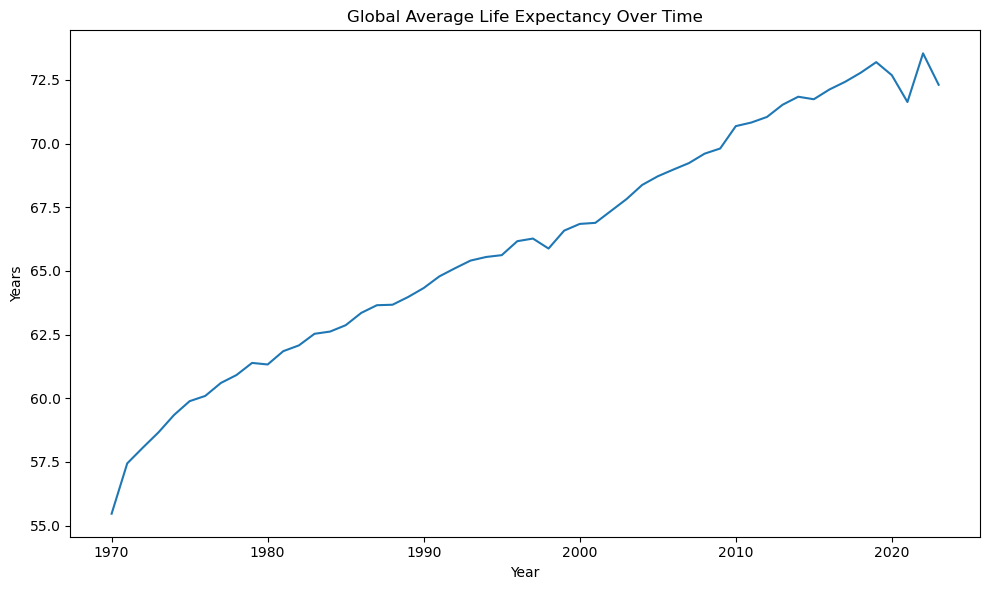

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Make sure columns are numeric
for col in ['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop rows with any missing indicator values
df = df_clean.dropna(subset=['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross'])

# --------------------------
# 1. Global Trend: Life Expectancy Over Time
# --------------------------
trend = df.groupby('Year')[['LifeExpectancy']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend, x='Year', y='LifeExpectancy')
plt.title("Global Average Life Expectancy Over Time")
plt.ylabel("Years")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

This plot shows the global average of life expectancy from 1960 to 2023. The steady increase reflects improvements in healthcare, nutrition, and living conditions worldwide.

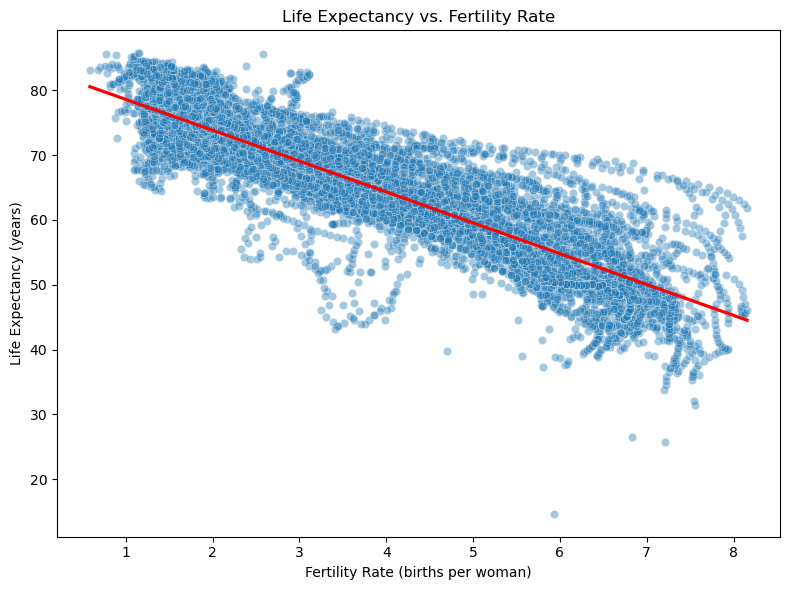

In [5]:
# --------------------------
# 2. Scatterplot: Life Expectancy vs Fertility Rate
# --------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='FertilityRate', y='LifeExpectancy', alpha=0.4)
sns.regplot(data=df, x='FertilityRate', y='LifeExpectancy', scatter=False, color='red')
plt.title("Life Expectancy vs. Fertility Rate")
plt.xlabel("Fertility Rate (births per woman)")
plt.ylabel("Life Expectancy (years)")
plt.tight_layout()
plt.show()

This scatterplot illustrates a strong inverse relationship: countries with higher fertility rates tend to have lower life expectancy. The fitted regression line highlights this negative correlation.

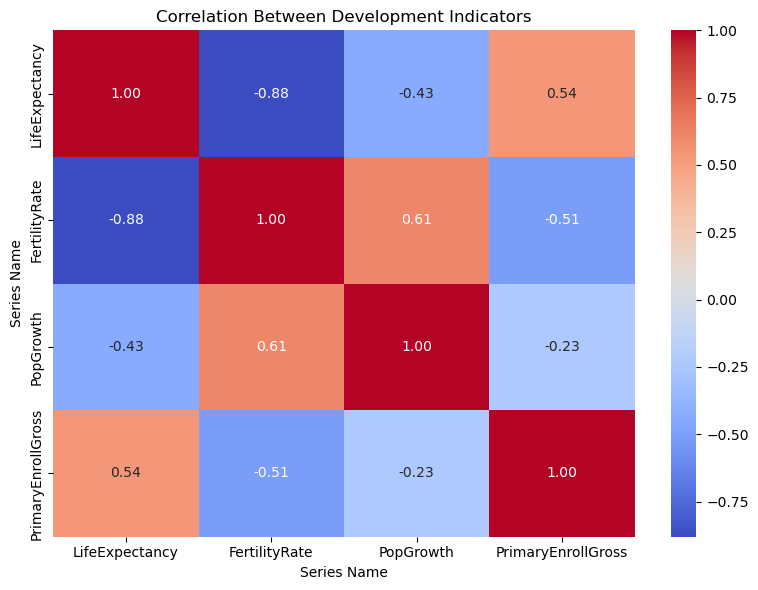

In [6]:
# --------------------------
# 3. Correlation Heatmap
# --------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df[['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Development Indicators")
plt.tight_layout()
plt.show()


This heatmap visualizes pairwise Pearson correlation coefficients among life expectancy, fertility rate, population growth, and school enrollment. Life expectancy is positively associated with school enrollment and negatively with fertility and population growth.

In [7]:
# --------------------------
# 4. Regression: Life Expectancy ~ Fertility + PopGrowth + School Enroll
# --------------------------
model = smf.ols("LifeExpectancy ~ FertilityRate + PopGrowth + PrimaryEnrollGross", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.481e+04
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:58:07   Log-Likelihood:                -32266.
No. Observations:               11020   AIC:                         6.454e+04
Df Residuals:                   11016   BIC:                         6.457e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             77.3726      0

This multivariate regression quantifies the combined effect of fertility rate, population growth, and school enrollment on life expectancy. All three predictors are statistically significant, reinforcing that education and controlled fertility support population health.

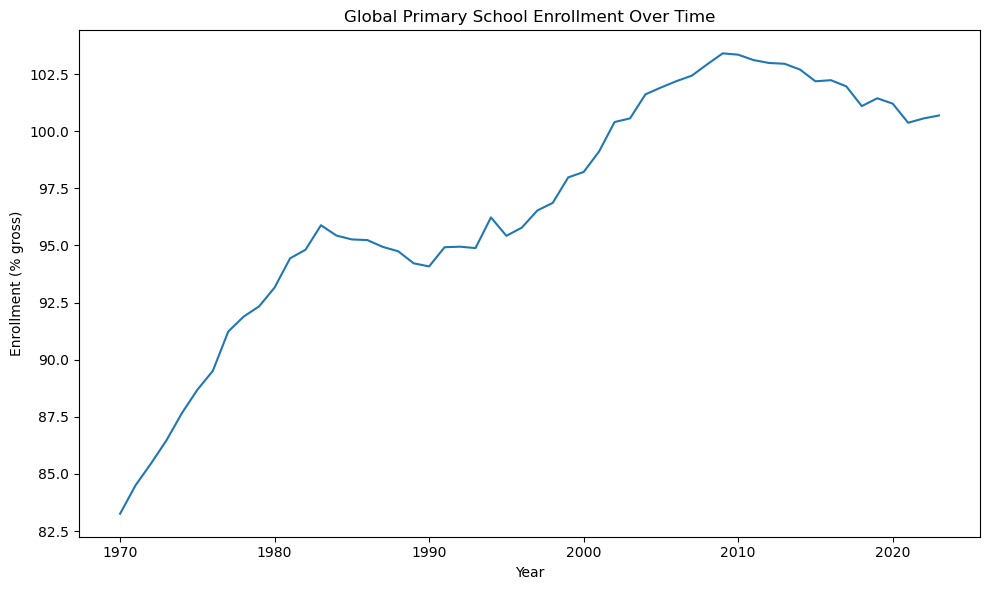

In [8]:
# --------------------------
# 5. School Enrollment Over Time
# --------------------------
enroll_trend = df.groupby('Year')[['PrimaryEnrollGross']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=enroll_trend, x='Year', y='PrimaryEnrollGross')
plt.title("Global Primary School Enrollment Over Time")
plt.xlabel("Year")
plt.ylabel("Enrollment (% gross)")
plt.tight_layout()
plt.show()

This line plot tracks global average primary school enrollment (% gross) over time. The steady upward trend signals progress in education access globally, especially in developing countries.

# Comparison Among Countries

In [9]:
unique_countries = df["Country Name"].unique()

In [10]:
countries_to_check = ["China", "United States", "Mexico", "Japan", "Belarus", "United Kingdom"]
presence_check = {country: country in unique_countries for country in countries_to_check}
presence_check

{'China': True,
 'United States': True,
 'Mexico': True,
 'Japan': True,
 'Belarus': True,
 'United Kingdom': True}

### Country Selection Rationale

For our analysis, we selected a subset of countries that represent both developing and developed regions. This allows us to compare developmental trajectories and uncover key differences and similarities in long-term trends.

The selected countries are:

- **China** *(representing developing economies in Asia)*
- **Japan** *(representing developed economies in Asia)*
- **Belarus** *(representing developing economies in Europe)*
- **United Kingdom** *(representing developed economies)*
- **Mexico** *(representing developing economies in North America)*
- **United States** *(representing developed economies in North America)*



By comparing indicators such as life expectancy, fertility rate, population growth, and school enrollment across these countries, we aim to explore how development strategies and socioeconomic factors influence demographic and educational outcomes. This dual perspective (developing vs. developed) provides valuable context for interpreting global development trends.

## Process of dataset

In [11]:

developed = {"United States", "Japan", "United Kingdom"}

df["Development Status"] = df["Country Name"].apply(
    lambda x: "Developed" if x in developed else "Developing"
)

# Optional: preview a few rows with country info included
df_filtered = df[["Country Name", "Year", "Development Status", 
                  "FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]]



/var/folders/sp/sr_dyzzd7fz_lm3r5g6s4s0m0000gp/T/ipykernel_33991/3521729589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Development Status"] = df["Country Name"].apply(


In [12]:
df_filtered.head()


Series Name,Country Name,Year,Development Status,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
0,Afghanistan,1970,Developing,7.400,37.460,2.445206,33.420010
1,Afghanistan,1971,Developing,7.432,37.932,2.428516,34.331341
2,Afghanistan,1972,Developing,7.453,38.423,2.442584,34.752682
3,Afghanistan,1973,Developing,7.487,38.951,2.534759,35.214371
4,Afghanistan,1974,Developing,7.526,39.469,2.526844,35.760830


In [13]:
selected_countries = [
    "China", "Japan", "Belarus", "United Kingdom", "Mexico", "United States"
]

df_subset = df_filtered[df_filtered["Country Name"].isin(selected_countries)]

In [14]:
df_subset.head(5)

Series Name,Country Name,Year,Development Status,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
1081,Belarus,1971,Developing,2.31,71.011707,0.832542,98.885452
1082,Belarus,1972,Developing,2.28,70.849317,0.801904,98.486702
1083,Belarus,1973,Developing,2.25,71.000659,0.740577,98.768021
1084,Belarus,1974,Developing,2.21,70.854683,0.649396,99.054001
1085,Belarus,1975,Developing,2.17,70.457098,0.528951,99.677994


## Comparison between Developing Country and Developed Country

In [15]:
df_subset = df_subset.rename(columns={
    'Development Status': 'Development_Status',
    'Country Name': 'Country_Name'
})

# Drop NA values
df_model = df_subset.dropna(subset=[
    'LifeExpectancy', 'FertilityRate', 'PrimaryEnrollGross',
    'Development_Status', 'Country_Name', 'Year'
])

# Run the model with country and year fixed effects
fe_model = smf.ols(
    formula='LifeExpectancy ~ FertilityRate * C(Development_Status) + PrimaryEnrollGross + C(Country_Name) + C(Year)',
    data=df_model
).fit()

# Print the results
print(fe_model.summary())


                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     38.49
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           4.83e-87
Time:                        03:58:28   Log-Likelihood:                -514.74
No. Observations:                 275   AIC:                             1153.
Df Residuals:                     213   BIC:                             1378.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

We estimated a linear regression model to evaluate how **fertility rate**, **primary school enrollment**, and **development status** relate to **life expectancy**, while controlling for **country-specific and year-specific effects** using fixed effects via dummy variables.

#### Model Specification:
$$
\begin{aligned}
\text{LifeExpectancy}_{it} =\ & 
\beta_0 + \beta_1 \cdot \text{FertilityRate}_{it} + \beta_2 \cdot \text{DevelopmentStatus}_i \\
& + \beta_3 \cdot (\text{FertilityRate} \times \text{DevelopmentStatus}) \\
& + \beta_4 \cdot \text{PrimaryEnrollGross}_{it} \\
& + \text{Country FE}_i + \text{Year FE}_t + \epsilon_{it}
\end{aligned}
$$

#### Key Findings:
- **R-squared = 0.917** and **Adjusted R-squared = 0.893**: The model explains a very high proportion of the variance in life expectancy.
- **Fertility Rate** is strongly and negatively associated with life expectancy in developed countries. This effect is moderated (weaker) in developing countries.
- **Primary School Enrollment (Gross)** is included as a control but was not statistically significant in this specification.
- **Country fixed effects** capture large differences in baseline life expectancy:
  - Japan (+22.13), United Kingdom (+20.71), United States (+19.33), Mexico (+3.74), and China (+1.69) show significantly higher life expectancy compared to the baseline country Belarus.
- **Year fixed effects** are mostly small and statistically insignificant, suggesting minimal change across years once other factors are accounted for.
  

#### Summary:
This fixed effects model confirms that **fertility rate remains a strong predictor of life expectancy**, particularly in developed countries. Country-level differences dominate the life expectancy gap, as captured by the country fixed effects. The interaction between fertility and development status reveals that the negative relationship between fertility and life expectancy is **much steeper in developed countries** than in developing ones.



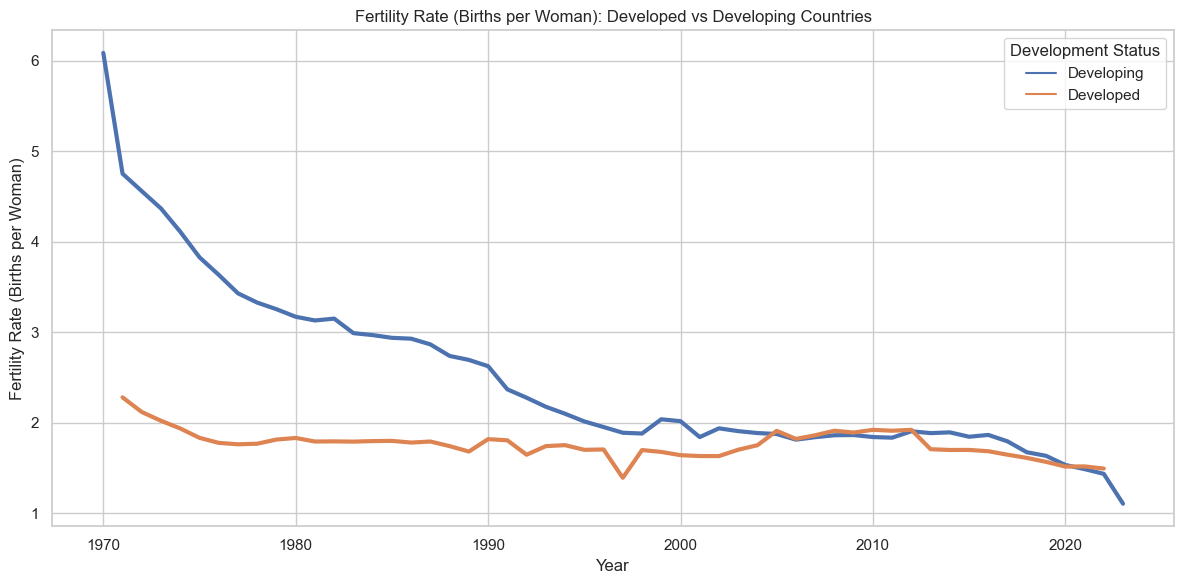

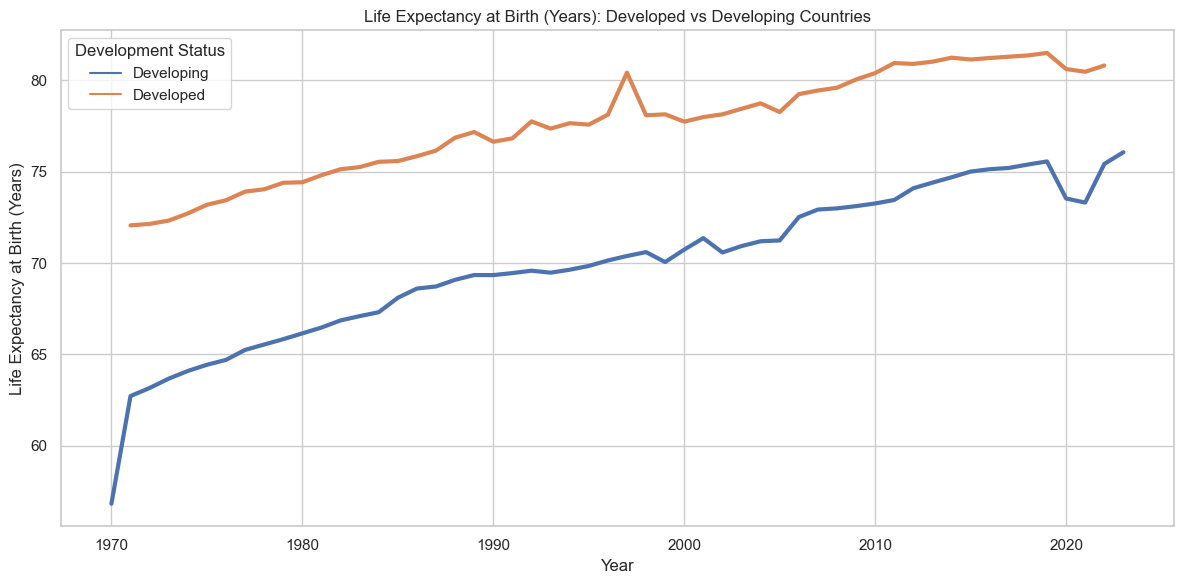

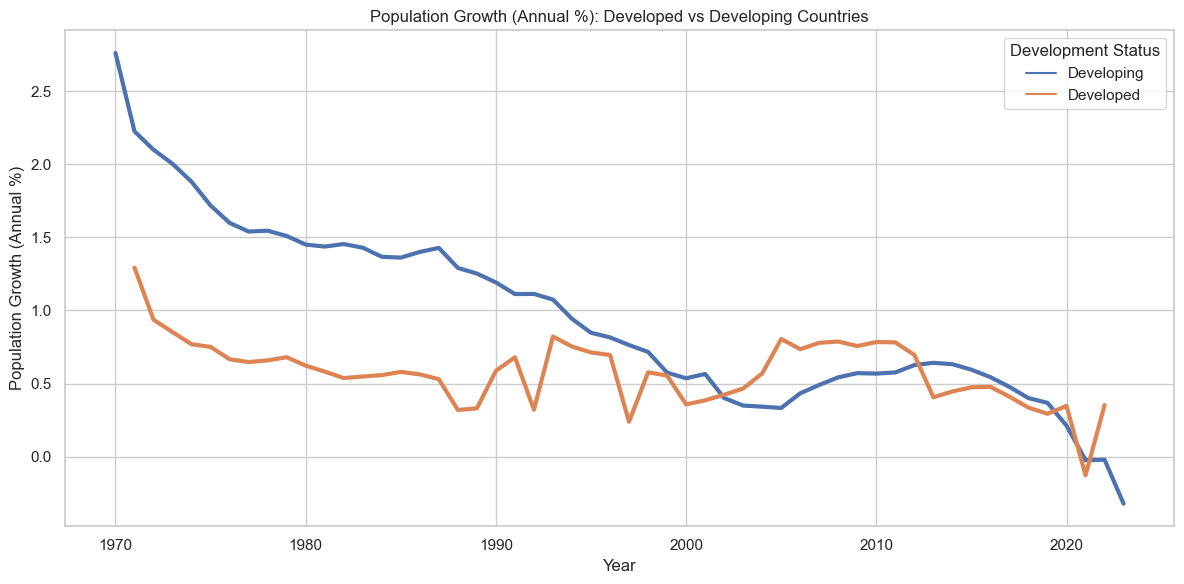

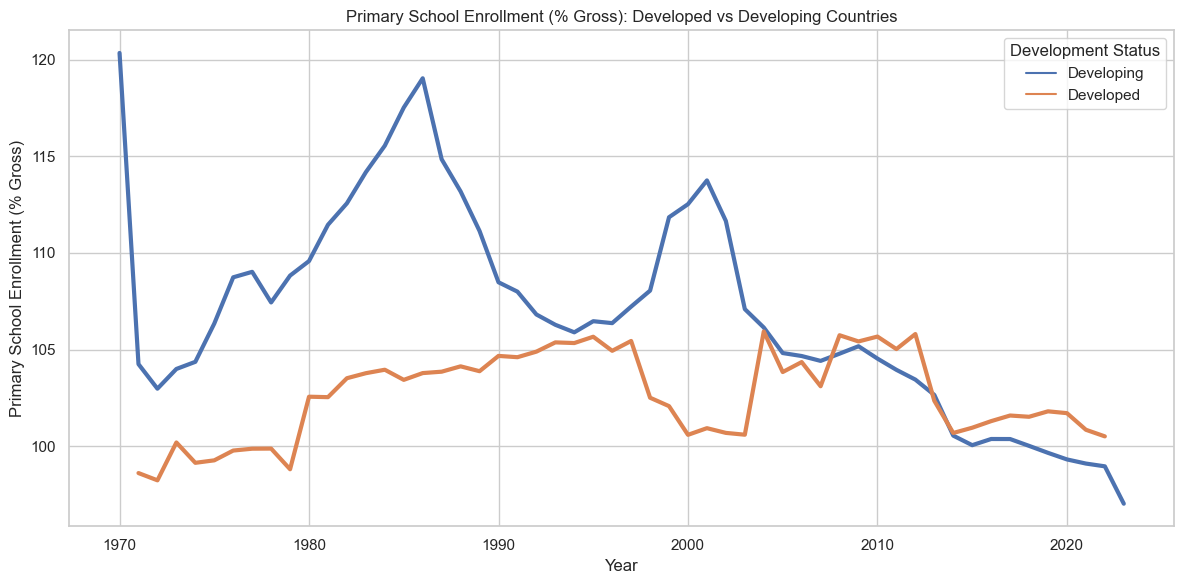

In [16]:
df_mean = df_subset.groupby(["Year", "Development_Status"])[
    ["FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]
].mean().reset_index()

# Plot style
sns.set(style="whitegrid")

# Indicator titles
indicators = ["FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]
titles = {
    "FertilityRate": "Fertility Rate (Births per Woman)",
    "LifeExpectancy": "Life Expectancy at Birth (Years)",
    "PopGrowth": "Population Growth (Annual %)",
    "PrimaryEnrollGross": "Primary School Enrollment (% Gross)"
}

for indicator in indicators:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x="Year", y=indicator, hue="Development_Status", linewidth=3)
    plt.title(f"{titles[indicator]}: Developed vs Developing Countries")
    plt.xlabel("Year")
    plt.ylabel(titles[indicator])
    plt.legend(title="Development Status")
    plt.tight_layout()
    plt.show()

# Compute the Rate of Change

In [19]:

def avg_yearly_change_flexible(df, var):
    df_var = df[["Year", var, "Country_Name"]].dropna()
    
    grouped = df_var.groupby("Country_Name")
    first = grouped.apply(lambda x: x.sort_values("Year").iloc[0])
    last = grouped.apply(lambda x: x.sort_values("Year").iloc[-1])

    rate = (last[var].values - first[var].values) / (last["Year"].values - first["Year"].values)
    return pd.Series(rate, index=grouped.groups.keys(), name=f"{var}_AvgChangePerYear")

change_fertility = avg_yearly_change_flexible(df_subset, "FertilityRate")
change_lifeexp = avg_yearly_change_flexible(df_subset, "LifeExpectancy")
change_popgrowth = avg_yearly_change_flexible(df_subset, "PopGrowth")
change_enroll = avg_yearly_change_flexible(df_subset, "PrimaryEnrollGross")

df_avg_change_flexible = pd.concat([change_fertility, change_lifeexp, change_popgrowth, change_enroll], axis=1).reset_index()
df_avg_change_flexible = df_avg_change_flexible.rename(columns={"index": "Country_Name"})

In [20]:

df_avg_change_flexible_rounded = df_avg_change_flexible.copy()
numeric_cols = df_avg_change_flexible_rounded.select_dtypes(include='number').columns
df_avg_change_flexible_rounded[numeric_cols] = df_avg_change_flexible_rounded[numeric_cols].round(3)

In [21]:
display(df_avg_change_flexible_rounded)

,Country_Name,FertilityRate_AvgChangePerYear,LifeExpectancy_AvgChangePerYear,PopGrowth_AvgChangePerYear,PrimaryEnrollGross_AvgChangePerYear
0,Belarus,-0.021,0.061,-0.026,-0.080
1,China,-0.096,0.399,-0.054,-0.397
2,Japan,-0.018,0.219,-0.052,0.047
3,Mexico,-0.088,0.285,-0.046,0.002
4,United Kingdom,-0.017,0.171,0.014,-0.030
5,United States,-0.012,0.124,-0.018,0.095


#### Summary:

Over the observed period, all six countries experienced a **decline in fertility rates**, with **China** showing the steepest average yearly decrease at **-0.096 births per woman per year**, followed by **Mexico** at **-0.088**. In contrast, **the United States** and **United Kingdom** saw the smallest fertility declines. **Life expectancy increased** across all countries, with **China** again leading in improvement (**+0.399 years per year**), while **Belarus** showed the smallest gain (**+0.061**). **Population growth rates** declined in every country except the **United Kingdom**, which had a slight increase. Trends in **primary school enrollment** were mixed: **Belarus** and **China** experienced notable declines, while **Japan** and the **United States** saw modest increases. These patterns reflect how demographic and development dynamics have evolved differently across developed and developing nations.

# Difference Among Continents

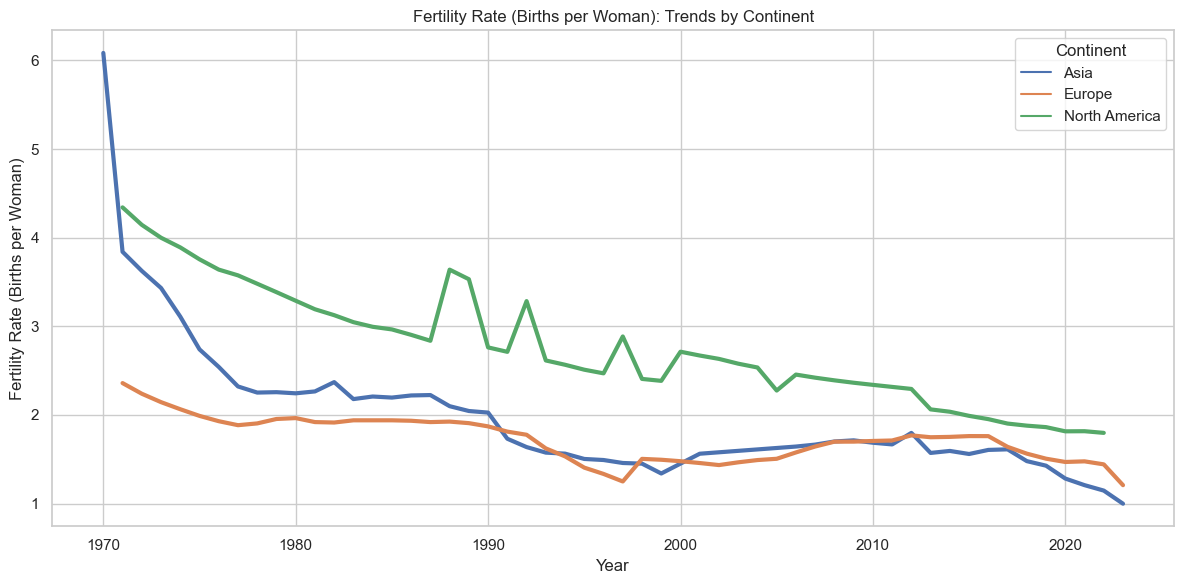

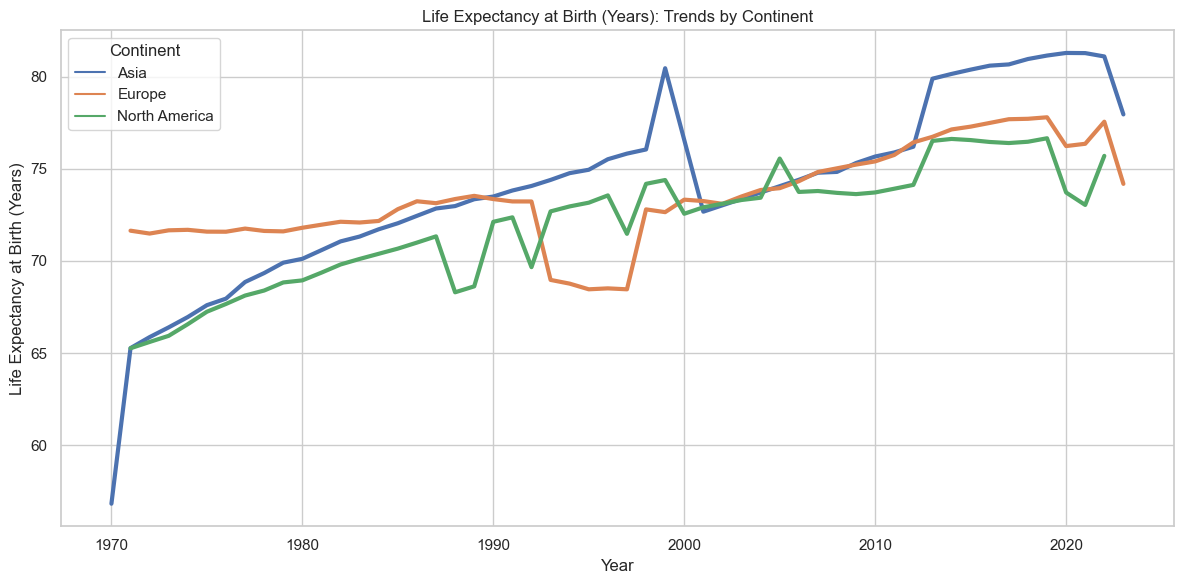

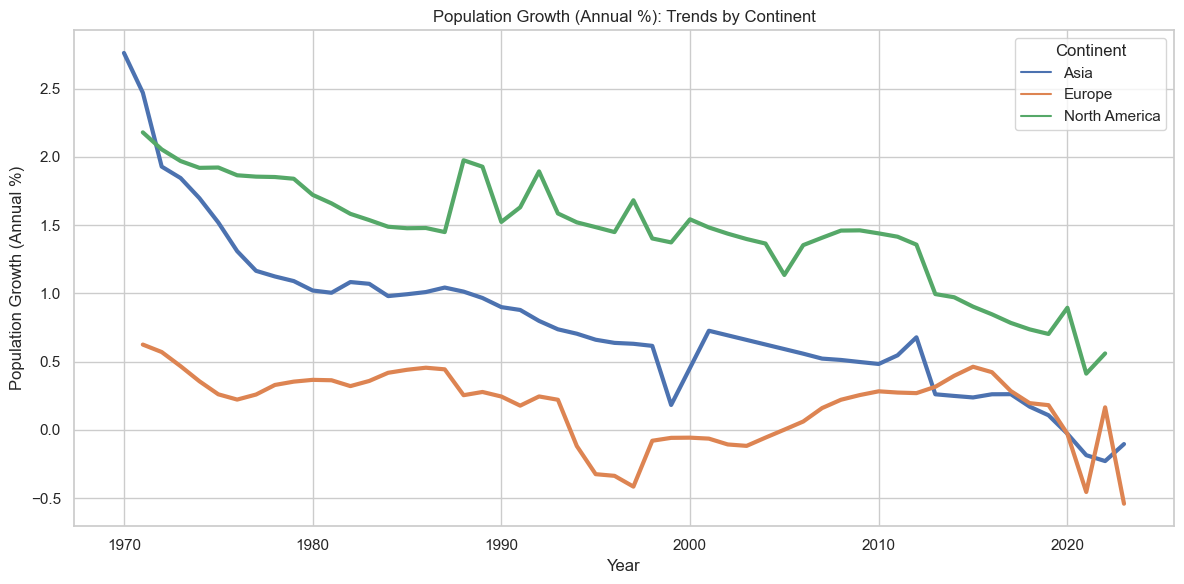

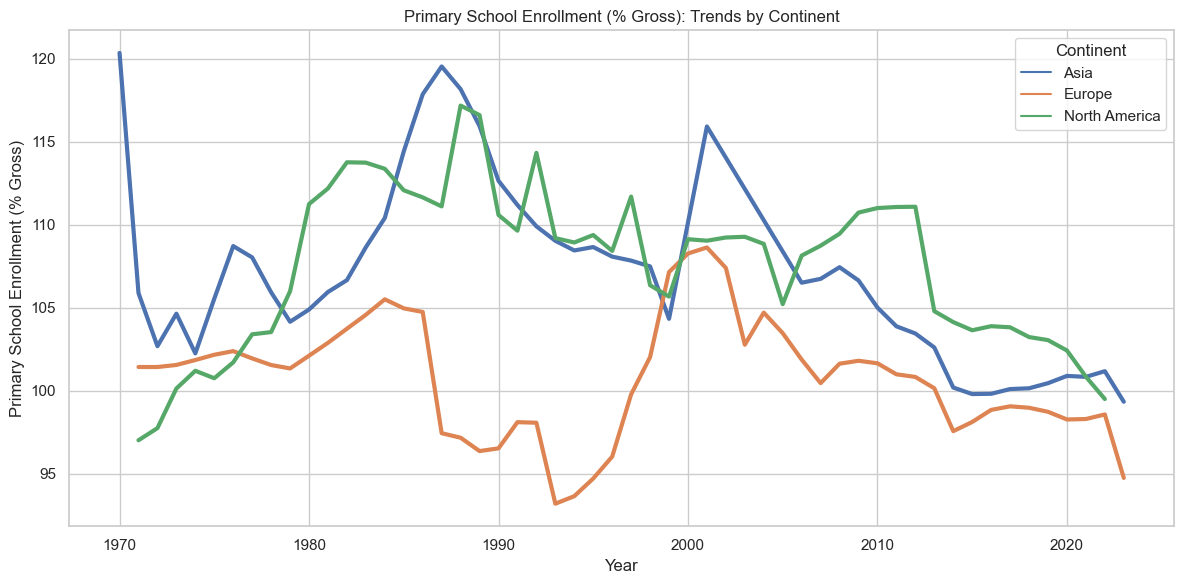

In [22]:
continent_map = {
    "China": "Asia",
    "Japan": "Asia",
    "United States": "North America",
    "Mexico": "North America",
    "United Kingdom": "Europe",
    "Belarus": "Europe"
}
df_subset["Continent"] = df_subset["Country_Name"].map(continent_map)

# Group and average indicators by Year + Continent
df_continent_mean = df_subset.groupby(["Year", "Continent"])[
    ["FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]
].mean().reset_index()

# Plot setup
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
titles = {
    "FertilityRate": "Fertility Rate (Births per Woman)",
    "LifeExpectancy": "Life Expectancy at Birth (Years)",
    "PopGrowth": "Population Growth (Annual %)",
    "PrimaryEnrollGross": "Primary School Enrollment (% Gross)"
}

# Plot all indicators by continent
for indicator in titles:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_continent_mean, x="Year", y=indicator, hue="Continent", linewidth=3)
    plt.title(f"{titles[indicator]}: Trends by Continent")
    plt.xlabel("Year")
    plt.ylabel(titles[indicator])
    plt.legend(title="Continent")
    plt.tight_layout()
    plt.show()

## How Education Impacts Economy Growth

In [39]:
import sqlite3

# Create an in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Write the DataFrame to the database
df_clean.to_sql("education", conn, index=False, if_exists='replace')

14290

In [40]:
query = """
SELECT 
    [Country Name], [Country Code],
    AVG(PrimaryEnrollGross) AS avg_primary_enroll,
    AVG(FertilityRate) AS avg_fertility,
    AVG(LifeExpectancy) AS avg_life_expectancy,
    AVG(PopGrowth) AS avg_pop_growth
FROM education
WHERE PrimaryEnrollGross IS NOT NULL
GROUP BY [Country Name]
ORDER BY avg_primary_enroll DESC
"""


# Run the query and store in a DataFrame
df_avg = pd.read_sql_query(query, conn)

# Show the results
display(df_avg)


,Country Name,Country Code,avg_primary_enroll,avg_fertility,avg_life_expectancy,avg_pop_growth
0,Sint Maarten (Dutch part),SXM,257.434204,1.447000,76.371000,1.437213
1,"Micronesia, Fed. Sts.",FSM,140.845830,4.619909,63.924727,1.204069
2,Monaco,MCO,135.037238,2.078067,79.731267,0.836504
3,Curacao,CUW,132.780200,1.566667,76.513333,-0.632003
4,Gabon,GAB,132.458891,5.142645,59.565742,2.556281
...,...,...,...,...,...,...
252,Ethiopia,ETH,52.922582,6.401020,49.939163,2.904475
253,Mali,MLI,47.551066,6.896392,48.523510,2.492753
254,Burkina Faso,BFA,47.033326,6.342404,51.357808,2.665826
255,Niger,NER,39.094767,7.531434,47.939453,3.259057


In [41]:
gdp_raw = pd.read_csv('../datasets/GDP per Capita.csv', skiprows=4, encoding='latin1', on_bad_lines='warn')
# Step 1: Identify base columns to keep
base_cols = ['Country Name', 'Country Code']

# Keep only columns that are years from 1971 onward
year_cols = [col for col in gdp_raw.columns if col.isdigit() and int(col) >= 1970 and int(col) <= 2023]

gdp_cleaned = gdp_raw[base_cols + year_cols]

# Drop rows where all GDP data is NaN
gdp_cleaned = gdp_cleaned.dropna(subset=year_cols, how='all')

display(gdp_cleaned.head())

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26129.839062,27458.225331,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620
1,Africa Eastern and Southern,AFE,276.790056,294.874668,311.528018,389.808233,463.563182,479.176007,468.869876,518.465591,...,1656.107642,1479.564123,1329.777824,1520.171298,1538.924188,1493.780445,1344.080962,1522.590088,1628.024526,1659.515290
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,625.054942,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,415.707417
3,Africa Western and Central,AFW,218.674868,195.862430,230.071773,280.647467,368.299318,413.371325,480.453252,490.845698,...,2204.995700,1845.767804,1616.843198,1560.162999,1703.896392,1783.654365,1664.249176,1747.840549,1777.235012,1568.724310
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5005.999741,3213.902611,1807.952941,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2308.159767


In [42]:
# Step 1: Extract GDP values only (year columns)
gdp_values = gdp_cleaned.loc[:, gdp_cleaned.columns.str.isnumeric()].copy()

# Step 2: Calculate year-over-year percentage growth across columns (i.e., across years)
gdp_growth_rates = gdp_values.pct_change(axis=1) * 100

# Step 3: Compute the average annual GDP growth per country (row-wise)
gdp_cleaned['avg_gdp_growth'] = gdp_growth_rates.mean(axis=1, skipna=True)

# Preview result
display(gdp_cleaned[['Country Name', 'Country Code', 'avg_gdp_growth']].head())



,Country Name,Country Code,avg_gdp_growth
0,Aruba,ABW,4.808468
1,Africa Eastern and Southern,AFE,3.922093
2,Afghanistan,AFG,4.925890
3,Africa Western and Central,AFW,5.542960
4,Angola,AGO,5.839453


In [43]:
type_raw = pd.read_csv('../datasets/Income Group.csv', on_bad_lines='warn')
type_raw.head()

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


In [44]:
print(gdp_cleaned.shape)
print(type_raw.shape)

(262, 57)
(265, 6)


In [45]:
# Push both DataFrames to SQL
gdp_cleaned.to_sql("gdp", conn, index=False, if_exists="replace")
type_raw.to_sql("meta", conn, index=False, if_exists="replace")

# SQL query to join on 'Country Code'
query = """
SELECT 
    gdp.*, 
    meta.IncomeGroup, 
    meta.Region
FROM gdp
LEFT JOIN meta ON gdp.[Country Code] = meta.[Country Code]
"""

# Run query and load into pandas
df_joined = pd.read_sql_query(query, conn)

# Show result
display(df_joined.head())


,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2017,2018,2019,2020,2021,2022,2023,avg_gdp_growth,IncomeGroup,Region
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620,4.808468,High income,Latin America & Caribbean
1,Africa Eastern and Southern,AFE,276.790056,294.874668,311.528018,389.808233,463.563182,479.176007,468.869876,518.465591,...,1520.171298,1538.924188,1493.780445,1344.080962,1522.590088,1628.024526,1659.515290,3.922093,None,None
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,415.707417,4.925890,Low income,South Asia
3,Africa Western and Central,AFW,218.674868,195.862430,230.071773,280.647467,368.299318,413.371325,480.453252,490.845698,...,1560.162999,1703.896392,1783.654365,1664.249176,1747.840549,1777.235012,1568.724310,5.542960,None,None
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2308.159767,5.839453,Lower middle income,Sub-Saharan Africa


In [46]:
# Drop columns 1970 to 2023
gdp_years = [str(year) for year in range(1970, 2024)]
gdp_years = [col for col in df_joined.columns if col.isdigit() and int(col) >= 1970 and int(col) <= 2023]
df_joined = df_joined.drop(columns=gdp_years)

# Rename "Country Name" to "Country_Name"
df_joined = df_joined.rename(columns={"Country Name": "Country_Name"})


# Resolve duplicate columns by specifying suffixes or dropping unnecessary columns
df_avg = df_avg.merge(df_joined, on=["Country Code"], how="left", suffixes=("", "_joined"))

# Drop unnecessary duplicate columns if needed
df_avg = df_avg.loc[:, ~df_avg.columns.str.endswith("_joined")]

df_avg



,Country Name,Country Code,avg_primary_enroll,avg_fertility,avg_life_expectancy,avg_pop_growth,Country_Name,avg_gdp_growth,IncomeGroup,Region
0,Sint Maarten (Dutch part),SXM,257.434204,1.447000,76.371000,1.437213,Sint Maarten (Dutch part),3.369317,High income,Latin America & Caribbean
1,"Micronesia, Fed. Sts.",FSM,140.845830,4.619909,63.924727,1.204069,"Micronesia, Fed. Sts.",5.048612,Lower middle income,East Asia & Pacific
2,Monaco,MCO,135.037238,2.078067,79.731267,0.836504,Monaco,6.620742,High income,Europe & Central Asia
3,Curacao,CUW,132.780200,1.566667,76.513333,-0.632003,Curacao,1.619427,High income,Latin America & Caribbean
4,Gabon,GAB,132.458891,5.142645,59.565742,2.556281,Gabon,7.157150,Upper middle income,Sub-Saharan Africa
...,...,...,...,...,...,...,...,...,...,...
252,Ethiopia,ETH,52.922582,6.401020,49.939163,2.904475,Ethiopia,5.397739,Low income,Sub-Saharan Africa
253,Mali,MLI,47.551066,6.896392,48.523510,2.492753,Mali,6.057693,Low income,Sub-Saharan Africa
254,Burkina Faso,BFA,47.033326,6.342404,51.357808,2.665826,Burkina Faso,5.415783,Low income,Sub-Saharan Africa
255,Niger,NER,39.094767,7.531434,47.939453,3.259057,Niger,3.953053,Low income,Sub-Saharan Africa


In [51]:
df_avg.shape

(257, 10)

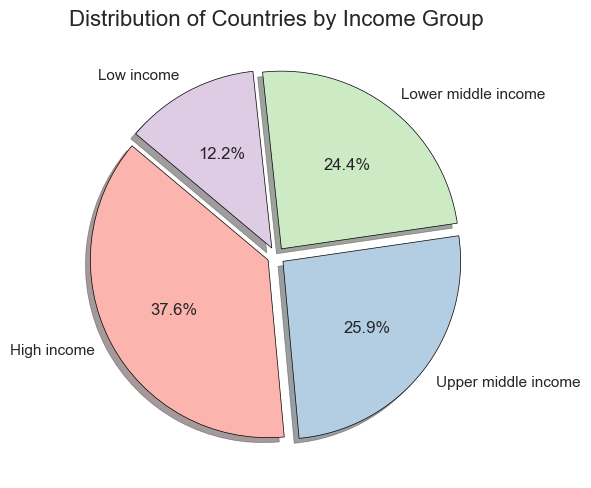

In [53]:

# Count number of countries in each income group
income_counts = df_avg['IncomeGroup'].value_counts()

# Extract values and labels
labels = income_counts.index
sizes = income_counts.values

# Explode effect: slightly "pop out" each wedge for 3D illusion
explode = [0.05] * len(labels)  # same offset for all wedges

# Colors (custom or pastel)
colors = plt.cm.Pastel1.colors[:len(labels)]

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    shadow=True,          
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)

plt.title("Distribution of Countries by Income Group", fontsize=16)
plt.tight_layout()
plt.show()


In [62]:
import numpy as np
# Group by Country Code and compute average rate of change for PrimaryEnrollGross
enroll_growth_list = []

for code, group in df_clean[df_clean['PrimaryEnrollGross'].notnull()].groupby("Country Code"):
    group = group.sort_values("Year")
    enroll = group["PrimaryEnrollGross"].values
    years = group["Year"].values
    
    if len(enroll) >= 2:
        growth_rates = np.diff(enroll) / np.diff(years)
        avg_growth = np.mean(growth_rates)
        enroll_growth_list.append({'Country Code': code, 'avg_enroll_growth': avg_growth})

# Create DataFrame of growth values
df_enroll_growth = pd.DataFrame(enroll_growth_list)

df_enroll_growth.shape
# Merge df_avg into df_enroll_growth
df_enroll_growth = df_enroll_growth.merge(df_avg, on="Country Code", how="left")

df_enroll_growth

,Country Code,avg_enroll_growth,Country Name,avg_primary_enroll,avg_fertility,avg_life_expectancy,avg_pop_growth,Country_Name,avg_gdp_growth,IncomeGroup,Region
0,ABW,-0.239972,Aruba,113.250343,1.823000,74.301130,0.839998,Aruba,4.808468,High income,Latin America & Caribbean
1,AFE,0.835771,Africa Eastern and Southern,83.856673,5.765313,53.739982,2.826159,Africa Eastern and Southern,3.922093,None,None
2,AFG,1.777806,Afghanistan,62.809384,7.009977,50.190955,2.456692,Afghanistan,4.925890,Low income,South Asia
3,AFW,0.892699,Africa Western and Central,76.693447,6.087842,50.352085,2.726230,Africa Western and Central,5.542960,None,None
4,AGO,-2.407502,Angola,95.495074,6.791621,48.716276,3.485185,Angola,5.839453,Lower middle income,Sub-Saharan Africa
...,...,...,...,...,...,...,...,...,...,...,...
251,WSM,0.282233,Samoa,97.271479,5.022667,68.472786,0.916565,Samoa,5.623533,Lower middle income,East Asia & Pacific
252,YEM,1.645224,"Yemen, Rep.",80.738378,5.344917,65.657583,3.046370,"Yemen, Rep.",0.447849,Low income,Middle East & North Africa
253,ZAF,-0.063805,South Africa,99.142983,3.134220,60.319341,1.789902,South Africa,4.485123,Upper middle income,Sub-Saharan Africa
254,ZMB,0.125477,Zambia,96.075963,6.174574,53.787128,2.997023,Zambia,3.831390,Lower middle income,Sub-Saharan Africa


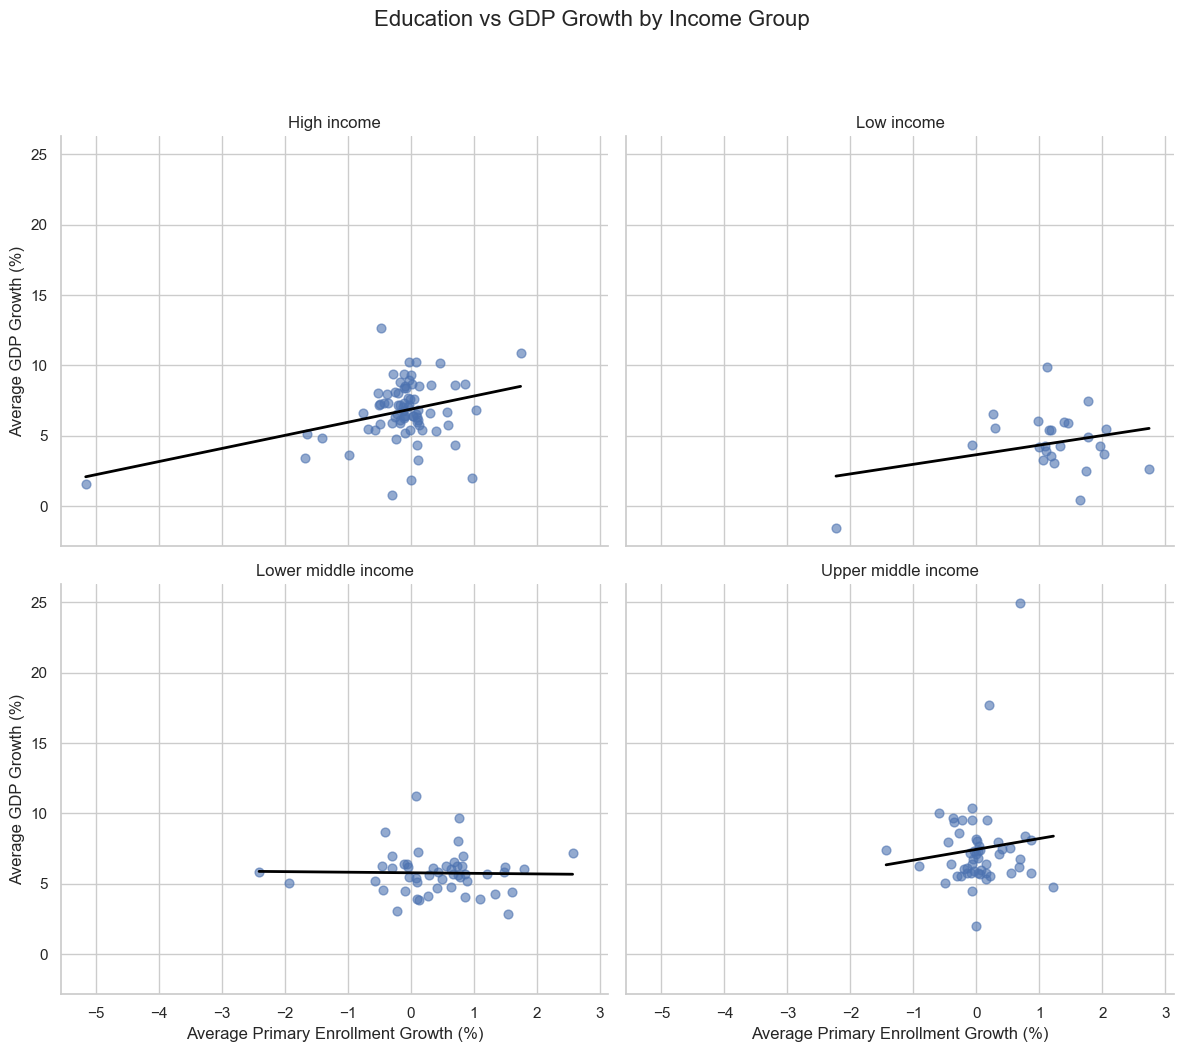

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the visual style
sns.set(style="whitegrid")

# Create a FacetGrid of scatter plots with regression lines by income group
g = sns.FacetGrid(
    df_enroll_growth,
    col="IncomeGroup",
    col_wrap=2,
    height=5,
    aspect=1.2,
    sharex=True,
    sharey=True
)

# Add scatter plots with regression lines
g.map_dataframe(
    sns.regplot,
    x="avg_enroll_growth",
    y="avg_gdp_growth",
    scatter_kws={"alpha": 0.6, "s": 40},
    line_kws={"color": "black", "linewidth": 2},
    ci=None
)

# Adjust plot labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Primary Enrollment Growth (%)", "Average GDP Growth (%)")
g.fig.suptitle("Education vs GDP Growth by Income Group", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()



#### Summary:

The facet scatter plots provide a comparative visualization of the relationship between average primary school enrollment growth and average GDP growth across four income groups. In **high-income countries**, we observe a moderately positive correlation, suggesting that even modest improvements in education enrollment may align with stronger economic performance. For **low-income countries**, the relationship also appears slightly positive but weaker and more dispersed, indicating that factors beyond education might play larger roles in driving economic growth. **Upper middle-income countries** show a very weak positive trend with limited variation in both variables, while **lower middle-income countries** display an almost flat relationship, suggesting little to no association between enrollment growth and GDP growth. Overall, the strength of the association appears more pronounced in high-income contexts, possibly due to more developed infrastructures allowing education gains to more directly influence economic productivity.

### Further Discussion:

#### Why is the Relationship Between Education Growth and GDP Growth Flat in Lower Middle Income Countries?

In the scatter plot analysis, we observed that for **lower middle income countries**, the relationship between **average primary enrollment growth** and **average GDP growth** appears relatively flat, indicating a weak or negligible correlation. This raises an important question:

> **Why might increased education growth not strongly correlate with economic growth in lower middle income countries?**

#### Potential Explanations:

1. **Quality of Education Over Quantity**  
   While enrollment rates may be increasing, the **quality of education**—including resources, teacher training, and curriculum—may still be lacking. Simply enrolling more students does not guarantee economic productivity unless those students gain market-relevant skills.

2. **Mismatch Between Education and Labor Market**  
   These countries may face a **skills mismatch**, where the education system does not align well with the demands of the labor market. This could result in underemployment or unemployment even as education levels rise.

3. **Delayed Economic Impact**  
   The effects of improved education might not be immediate. **GDP growth may lag behind** educational investments, especially if infrastructure and industry are not prepared to absorb a more educated workforce.

4. **Structural Barriers**  
   Factors such as **political instability**, **corruption**, or **poor governance** may dilute the economic impact of educational reforms. Even with growing enrollment, systemic inefficiencies can hinder economic development.

5. **Informal Economy Prevalence**  
   Many lower middle income countries have large **informal economies**. In such contexts, formal education may have limited influence on income generation, which can weaken the observable link to GDP growth.

---

This analysis highlights that **educational expansion alone is not a silver bullet**. It must be paired with complementary investments in infrastructure, governance, and economic diversification to translate human capital development into tangible economic outcomes.
